Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error


Upload Dataset

In [5]:
from google.colab import files
uploaded = files.upload()


Saving movies.csv to movies (2).csv
Saving ratings.csv to ratings (2).csv


Load Data

In [6]:
movies = pd.read_csv("/content/ratings (2).csv")
ratings = pd.read_csv("/content/movies (2).csv")

print("Movies Shape:", movies.shape)
print("Ratings Shape:", ratings.shape)

movies.head()


Movies Shape: (105339, 4)
Ratings Shape: (10329, 3)


,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


Basic EDA

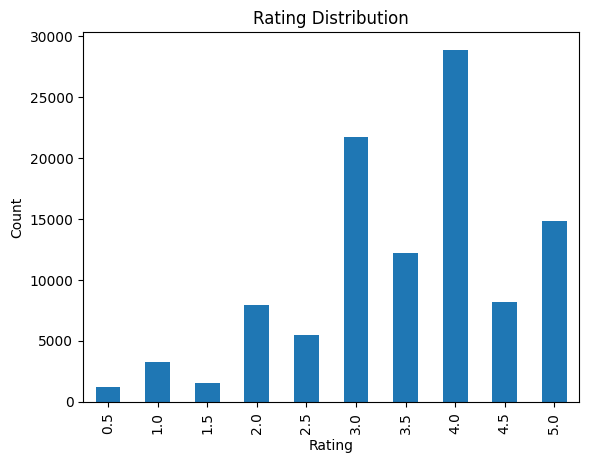

In [8]:
movies['rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

CONTENT-BASED FILTERING

In [10]:
ratings['genres'] = ratings['genres'].fillna('')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(ratings['genres'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

indices = pd.Series(ratings.index, index=ratings['title']).drop_duplicates()

def content_recommend(title, top_n=5):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return ratings['title'].iloc[movie_indices]

content_recommend("Toy Story (1995)")

,title
1815,Antz (1998)
2496,Toy Story 2 (1999)
2967,"Adventures of Rocky and Bullwinkle, The (2000)"
3166,"Emperor's New Groove, The (2000)"
3811,"Monsters, Inc. (2001)"


COLLABORATIVE FILTERING (Manual SVD)
Create User-Item Matrix

In [12]:
user_item = movies.pivot(index='userId',
                          columns='movieId',
                          values='rating')

user_item_filled = user_item.fillna(0)

user_item_filled.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Apply Matrix Factorization (SVD)

In [13]:
matrix = user_item_filled.values

U, sigma, Vt = svds(matrix, k=50)

sigma = np.diag(sigma)

predicted_ratings = np.dot(np.dot(U, sigma), Vt)

pred_df = pd.DataFrame(predicted_ratings,
                       columns=user_item_filled.columns,
                       index=user_item_filled.index)

pred_df.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
userId,,,,,,,,,,,,,,,,,,,,,
1,2.353881,0.117379,0.187535,-0.042743,0.064059,1.551164,0.103875,-0.033032,0.186680,0.996452,...,-0.021833,-0.028894,-0.006939,-0.016511,-0.053876,-0.044451,-0.027782,-0.024766,0.010340,-0.033021
2,3.166808,0.202603,1.658729,-0.078063,1.482022,1.735933,1.165243,0.025959,0.764693,-0.207700,...,-0.000701,-0.008628,-0.007624,-0.004930,-0.008329,0.023519,0.014699,-0.007395,-0.049745,-0.009860
3,0.995895,0.827381,0.546070,0.189762,0.574514,0.327878,0.764201,0.042447,0.018550,1.700038,...,0.011118,0.004543,0.012137,0.002596,0.018718,0.027190,0.016994,0.003894,-0.045972,0.005192
4,0.647540,-0.224632,-0.255055,0.133363,-0.106713,0.127758,-0.126595,-0.049978,-0.007807,0.001401,...,0.026494,0.044022,-0.031219,0.025155,0.073059,0.002995,0.001872,0.037733,-0.052659,0.050310
5,1.619112,0.413215,0.096732,-0.027260,0.088065,-0.133518,-0.003296,0.010433,0.030401,0.319028,...,0.018970,-0.010827,0.000169,-0.006187,0.016012,0.021340,0.013337,-0.009280,0.013359,-0.012374


Collaborative Recommendation Function

In [15]:
def collaborative_recommend(user_id, top_n=5):
    user_predictions = pred_df.loc[user_id].sort_values(ascending=False)

    watched_movies = movies[movies['userId'] == user_id]['movieId'].values

    recommendations = [movie for movie in user_predictions.index
                       if movie not in watched_movies][:top_n]

    return ratings[ratings['movieId'].isin(recommendations)]['title']

collaborative_recommend(1)

,title
0,Toy Story (1995)
484,Blade Runner (1982)
1050,Indiana Jones and the Last Crusade (1989)
3322,Memento (2000)
7669,"Dark Knight, The (2008)"


HYBRID RECOMMENDATION

In [17]:
def hybrid_recommend(user_id, title, top_n=5):
    content_list = content_recommend(title, top_n*2)

    hybrid_scores = []

    for movie in content_list:
        # Corrected: Use 'ratings' DataFrame to find movieId from title
        movie_id_row = ratings[ratings['title'] == movie]
        if not movie_id_row.empty:
            movie_id = movie_id_row['movieId'].values[0]
            predicted_rating = pred_df.loc[user_id, movie_id]
            hybrid_scores.append((movie, predicted_rating))

    hybrid_scores = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)

    return [movie[0] for movie in hybrid_scores[:top_n]]

hybrid_recommend(1, "Toy Story (1995)")

['Monsters, Inc. (2001)',
 'Toy Story 2 (1999)',
 "Emperor's New Groove, The (2000)",
 'Adventures of Rocky and Bullwinkle, The (2000)',
 'Antz (1998)']

RMSE Evaluation

We compare actual ratings vs predicted ratings.

In [19]:
actual = []
predicted = []

for row in movies.itertuples(): # Changed from ratings.itertuples()
    user = row.userId
    movie = row.movieId
    rating = row.rating

    if user in pred_df.index and movie in pred_df.columns:
        actual.append(rating)
        predicted.append(pred_df.loc[user, movie])

rmse = np.sqrt(mean_squared_error(actual, predicted))
print("RMSE:", rmse)

RMSE: 2.0279644268239245


Save Model

In [20]:
import pickle

with open("svd_predictions.pkl", "wb") as f:
    pickle.dump(pred_df, f)


In [21]:
files.download("svd_predictions.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>